In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from sklearn.linear_model import LinearRegression,LogisticRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import skew

ImportError: cannot import name 'xgb' from 'xgboost' (C:\Users\Jeevisha\Anaconda3\lib\site-packages\xgboost\__init__.py)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data = pd.read_csv('yellow_tripdata_2019-01.csv')

In [5]:
zone =  pd.read_csv('taxi+_zone_lookup.csv')

In [6]:
data.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4855978
dtype: int64

Removing congestion_surcharge 

In [7]:
#df =  data.drop(columns = 'congestion_surcharge')
df = data.copy()

Merging ride data and zone lookup data to get the zone name and borough name for pickup location

In [8]:
merged_df = pd.merge(left=df,right=zone, left_on='PULocationID', right_on='LocationID')

In [9]:
merged_df.rename(columns={'Borough':'PUBorough','Zone':'PUZone','service_zone':'PU_service_zone'},inplace=True)

In [10]:
merged_df.shape

(7667792, 22)

Merging ride data and zone lookup data to get the zone name and borough name for drop off location

In [11]:
final = pd.merge(left=merged_df,right=zone, left_on='DOLocationID', right_on='LocationID')

In [12]:
final.rename(columns={'Borough':'DOBorough','Zone':'DOZone','service_zone':'DO_service_zone'},inplace=True)

In [13]:
final.shape

(7667792, 26)

In [14]:
final.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'LocationID_x', 'PUBorough',
       'PUZone', 'PU_service_zone', 'LocationID_y', 'DOBorough', 'DOZone',
       'DO_service_zone'],
      dtype='object')

In [15]:
final.drop(columns=['LocationID_x','LocationID_y'],inplace=True)

In [16]:
final['tot1']=final['fare_amount'] + final['mta_tax'] + final['extra'] + final['tip_amount'] + final['improvement_surcharge'] + final['tolls_amount']

### Final Dataset

In [17]:
final.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUBorough,PUZone,PU_service_zone,DOBorough,DOZone,DO_service_zone,tot1
7667787,2,2019-01-03 22:28:00,2019-01-03 23:19:14,1,30.47,1,N,87,30,1,83.5,0.5,0.5,16.96,0.00,0.3,101.76,NaN,Manhattan,Financial District North,Yellow Zone,Queens,Broad Channel,Boro Zone,101.76
7667788,2,2019-01-25 18:09:18,2019-01-25 19:09:49,1,16.99,1,N,146,30,1,54.0,1.0,0.5,0.00,2.16,0.3,57.96,0.0,Queens,Long Island City/Queens Plaza,Boro Zone,Queens,Broad Channel,Boro Zone,57.96
7667789,2,2019-01-01 06:43:45,2019-01-01 07:11:24,1,10.86,1,N,205,30,1,33.5,0.0,0.5,1.82,2.16,0.3,40.23,NaN,Queens,Saint Albans,Boro Zone,Queens,Broad Channel,Boro Zone,38.28
7667790,2,2019-01-12 19:18:11,2019-01-12 19:37:07,1,7.22,1,N,201,30,1,23.0,0.0,0.5,5.19,2.16,0.3,31.15,NaN,Queens,Rockaway Park,Boro Zone,Queens,Broad Channel,Boro Zone,31.15
7667791,2,2019-01-29 23:49:34,2019-01-30 00:11:27,1,10.20,1,N,28,30,2,30.5,0.5,0.5,0.00,0.00,0.3,31.80,0.0,Queens,Briarwood/Jamaica Hills,Boro Zone,Queens,Broad Channel,Boro Zone,31.80


In [18]:
final['tpep_dropoff_datetime'] = pd.to_datetime(final['tpep_dropoff_datetime'])
final['tpep_pickup_datetime'] = pd.to_datetime(final['tpep_pickup_datetime'])

In [19]:
# month (pickup and dropoff)
final['mm_pickup'] = final.tpep_pickup_datetime.dt.month.astype(np.uint8)
final['mm_dropoff'] = final.tpep_dropoff_datetime.dt.month.astype(np.uint8)
# day of week
final['dow_pickup'] = final.tpep_pickup_datetime.dt.weekday.astype(np.uint8)
final['dow_dropoff'] = final.tpep_dropoff_datetime.dt.weekday.astype(np.uint8)
# day hour
final['hh_pickup'] = final.tpep_pickup_datetime.dt.hour.astype(np.uint8)
final['hh_dropoff'] = final.tpep_dropoff_datetime.dt.hour.astype(np.uint8)
# day minute
final['min_pickup'] = final.tpep_pickup_datetime.dt.minute.astype(np.uint8)
final['min_dropoff'] = final.tpep_dropoff_datetime.dt.minute.astype(np.uint8)

final['year_pickup'] = final.tpep_pickup_datetime.dt.year
final['year_dropoff'] = final.tpep_dropoff_datetime.dt.year

In [20]:
dow_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

In [21]:
final['dow_pickup']=final['dow_pickup'].map(dow_names)
final['dow_dropoff']=final['dow_dropoff'].map(dow_names)

In [22]:
zone['service_zone'].value_counts()

Boro Zone      205
Yellow Zone     55
Airports         2
EWR              1
Name: service_zone, dtype: int64

In [23]:
final_man = final[((final['PUBorough']=='Manhattan') & (final['DOBorough'] == 'Manhattan'))]

In [24]:
final_man['DO_service_zone'].value_counts()

Yellow Zone    6151431
Boro Zone       348567
Name: DO_service_zone, dtype: int64

In [25]:
final_man[final_man['mm_pickup']==12]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUBorough,PUZone,PU_service_zone,DOBorough,DOZone,DO_service_zone,tot1,mm_pickup,mm_dropoff,dow_pickup,dow_dropoff,hh_pickup,hh_dropoff,min_pickup,min_dropoff,year_pickup,year_dropoff
16,2,2018-12-31 23:06:33,2018-12-31 23:15:03,5,1.46,1,N,151,239,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16,NaN,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,11.16,12,12,Monday,Monday,23,23,6,15,2018,2018
46627,2,2008-12-31 23:23:44,2008-12-31 23:34:53,1,1.84,1,N,163,239,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30,NaN,Manhattan,Midtown North,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,10.30,12,12,Wednesday,Wednesday,23,23,23,34,2008,2008
57170,2,2018-12-31 17:44:18,2018-12-31 17:47:12,1,0.46,1,N,238,239,2,4.0,0.0,0.5,0.00,0.0,0.3,4.80,NaN,Manhattan,Upper West Side North,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,4.80,12,12,Monday,Monday,17,17,44,47,2018,2018
122191,2,2008-12-31 23:59:28,2009-01-01 00:09:41,1,1.50,1,N,142,239,1,8.5,0.0,0.5,1.86,0.0,0.3,11.16,NaN,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,11.16,12,1,Wednesday,Thursday,23,0,59,9,2008,2009
149163,2,2018-12-31 19:38:00,2018-12-31 19:54:49,1,2.90,1,N,48,239,1,13.0,0.5,0.5,3.58,0.0,0.3,17.88,NaN,Manhattan,Clinton East,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,17.88,12,12,Monday,Monday,19,19,38,54,2018,2018
231942,2,2018-12-31 17:02:42,2018-12-31 17:25:26,1,3.99,1,N,236,142,1,17.5,0.0,0.5,3.66,0.0,0.3,21.96,NaN,Manhattan,Upper East Side North,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,21.96,12,12,Monday,Monday,17,17,2,25,2018,2018
249899,2,2008-12-31 23:45:22,2008-12-31 23:53:08,2,0.92,1,N,163,142,2,6.5,0.0,0.5,0.00,0.0,0.3,7.30,NaN,Manhattan,Midtown North,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,7.30,12,12,Wednesday,Wednesday,23,23,45,53,2008,2008
284647,2,2018-12-31 23:59:46,2019-01-01 00:08:54,2,1.06,1,N,161,142,2,7.5,0.5,0.5,0.00,0.0,0.3,8.80,NaN,Manhattan,Midtown Center,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,8.80,12,1,Monday,Tuesday,23,0,59,8,2018,2019
334326,2,2008-12-31 23:09:10,2008-12-31 23:38:34,1,3.22,1,N,137,142,2,17.5,0.0,0.5,0.00,0.0,0.3,18.30,0.0,Manhattan,Kips Bay,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,18.30,12,12,Wednesday,Wednesday,23,23,9,38,2008,2008
403416,2,2018-12-31 18:45:10,2018-12-31 18:55:33,1,2.21,1,N,100,142,1,9.5,0.5,0.5,2.16,0.0,0.3,12.96,NaN,Manhattan,Garment District,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,12.96,12,12,Monday,Monday,18,18,45,55,2018,2018


In [26]:
final_man.groupby('year_pickup')['VendorID'].count()

year_pickup
2008         17
2009         38
2018        263
2019    6499678
2088          2
Name: VendorID, dtype: int64

In [27]:
final_man.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499998 entries, 0 to 7667706
Data columns (total 35 columns):
VendorID                 int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
PUBorough                object
PUZone                   object
PU_service_zone          object
DOBorough                object
DOZone                   object
DO_service_zone          object
tot1                     float64
mm_pickup                uint8
mm_dropoff               uint8
dow_p

In [28]:
final_man.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,tot1,mm_pickup,mm_dropoff,hh_pickup,hh_dropoff,min_pickup,min_dropoff,year_pickup,year_dropoff
count,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,2.389288e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06,6.499998e+06
mean,1.639739e+00,1.572379e+00,1.775679e+00,1.010873e+00,1.664102e+02,1.654355e+02,1.289408e+00,9.430245e+00,3.148725e-01,4.987078e-01,1.439145e+00,7.185910e-03,2.995034e-01,1.199337e+01,3.766813e-05,1.198966e+01,1.000495e+00,1.000623e+00,1.383742e+01,1.390327e+01,2.961647e+01,2.965488e+01,2.019000e+03,2.019000e+03
std,5.410282e-01,1.229013e+00,1.475343e+00,4.491462e-01,6.616241e+01,6.799507e+01,4.698080e-01,2.445355e+02,3.922666e-01,4.188989e-02,1.505231e+00,4.394277e-01,1.702807e-02,2.445565e+02,9.704068e-03,2.445564e+02,7.268522e-02,6.300243e-02,5.810144e+00,5.858123e+00,1.732360e+01,1.743227e+01,4.905559e-02,4.879620e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,-2.520000e+02,-6.000000e+01,-5.000000e-01,-6.350000e+01,-7.000000e+01,-3.000000e-01,-3.223000e+02,0.000000e+00,-3.223000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,2.008000e+03
25%,1.000000e+00,1.000000e+00,8.800000e-01,1.000000e+00,1.140000e+02,1.140000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,7.880000e+00,0.000000e+00,7.870000e+00,1.000000e+00,1.000000e+00,1.000000e+01,1.000000e+01,1.500000e+01,1.500000e+01,2.019000e+03,2.019000e+03
50%,2.000000e+00,1.000000e+00,1.390000e+00,1.000000e+00,1.630000e+02,1.620000e+02,1.000000e+00,8.000000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.055000e+01,0.000000e+00,1.055000e+01,1.000000e+00,1.000000e+00,1.400000e+01,1.500000e+01,3.000000e+01,3.000000e+01,2.019000e+03,2.019000e+03
75%,2.000000e+00,2.000000e+00,2.200000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.150000e+01,5.000000e-01,5.000000e-01,2.120000e+00,0.000000e+00,3.000000e-01,1.416000e+01,0.000000e+00,1.416000e+01,1.000000e+00,1.000000e+00,1.900000e+01,1.900000e+01,4.500000e+01,4.500000e+01,2.019000e+03,2.019000e+03
max,4.000000e+00,9.000000e+00,8.318000e+02,9.900000e+01,2.630000e+02,2.630000e+02,4.000000e+00,6.232599e+05,5.300000e+00,6.080000e+01,7.872500e+02,7.413200e+02,3.000000e-01,6.232617e+05,2.500000e+00,6.232617e+05,1.200000e+01,1.200000e+01,2.300000e+01,2.300000e+01,5.900000e+01,5.900000e+01,2.088000e+03,2.088000e+03


In [29]:
final_man = final_man[(final_man['year_pickup']==2019) & (final_man['year_dropoff']==2019) & (final_man['mm_pickup']==1) & (final_man['mm_dropoff']==1)]

In [30]:
plt.style.use('seaborn-white')

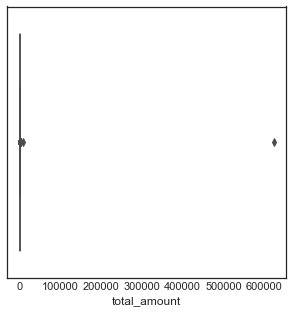

In [31]:
plt.figure(figsize=(5,5))
sns.boxplot('total_amount',data=final_man);

In [32]:
final_man.total_amount.describe(percentiles=[.25,.5,.75,.8,.85,.9,.95,.99])

count    6.497832e+06
mean     1.199226e+01
std      2.445972e+02
min     -3.223000e+02
25%      7.880000e+00
50%      1.055000e+01
75%      1.416000e+01
80%      1.536000e+01
85%      1.680000e+01
90%      1.896000e+01
95%      2.280000e+01
99%      3.130000e+01
max      6.232617e+05
Name: total_amount, dtype: float64

In [33]:
# final_man = final_man[((final_man['total_amount']>0) & (final_man['total_amount'] <= 300))]

In [34]:
final_man.tip_amount.describe(percentiles=[.25,.5,.75,.8,.85,.9,.95,.99])

count    6.497832e+06
mean     1.439015e+00
std      1.505098e+00
min     -6.350000e+01
25%      0.000000e+00
50%      1.360000e+00
75%      2.120000e+00
80%      2.350000e+00
85%      2.650000e+00
90%      3.000000e+00
95%      3.760000e+00
99%      5.450000e+00
max      7.872500e+02
Name: tip_amount, dtype: float64

considering tips less than 50% of fare amount  

In [35]:
final_man = final_man[(final_man['tip_amount']*100/final_man['fare_amount']<= 50) & (final_man['tip_amount'] <= 200)]

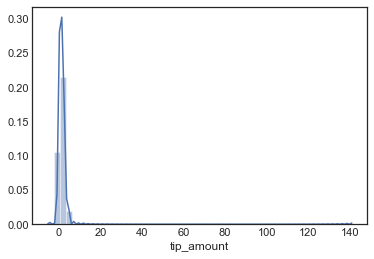

In [36]:
sns.distplot(final_man['tip_amount']);

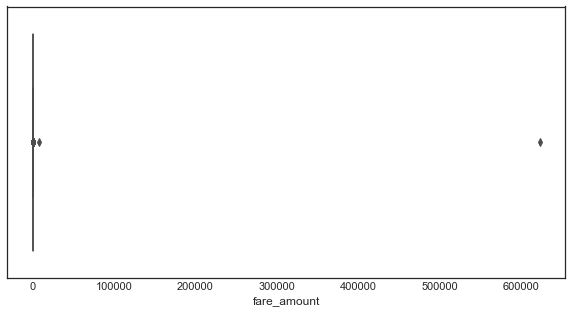

In [37]:
plt.figure(figsize=(10,5))
sns.boxplot('fare_amount',data=final_man);

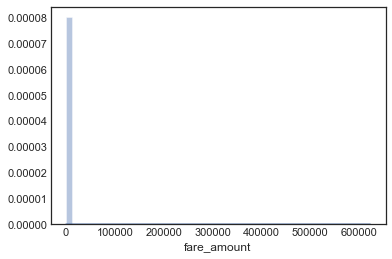

In [38]:
sns.distplot(final_man['fare_amount']);

In [39]:
final_man = final_man[((final_man['fare_amount']>0) & (final_man['fare_amount'] <= 300))]

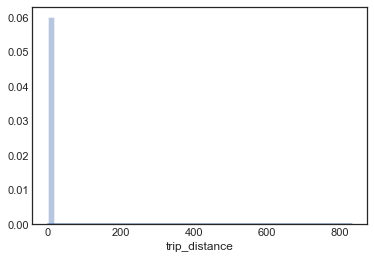

In [40]:
sns.distplot(final_man['trip_distance']);

In [41]:
final_man.trip_distance.describe(percentiles=[.25,.5,.75,.8,.85,.9,.95,.99])

count    6.467556e+06
mean     1.779143e+00
std      1.473828e+00
min      0.000000e+00
25%      8.800000e-01
50%      1.390000e+00
75%      2.200000e+00
80%      2.500000e+00
85%      2.890000e+00
90%      3.450000e+00
95%      4.600000e+00
99%      7.150000e+00
max      8.318000e+02
Name: trip_distance, dtype: float64

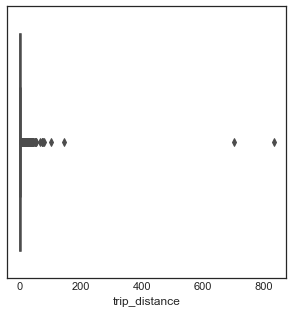

In [42]:
plt.figure(figsize=(5,5))
sns.boxplot('trip_distance',data=final_man);

Removing trip_distance > 200

In [43]:
final_man = final_man[((final_man['trip_distance'] <=200) & (final_man['trip_distance'] > 0))]

In [44]:
final_man.shape

(6444927, 35)

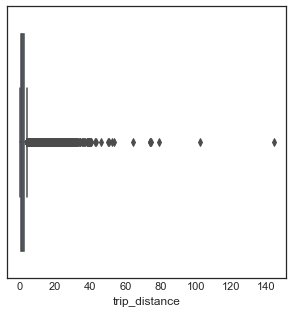

In [45]:
plt.figure(figsize=(5,5))
sns.boxplot('trip_distance',data=final_man);

Long distance trips with distance > 50 

In [46]:
final_man['dist_type'] = final_man['trip_distance'].apply(lambda x: 'long' if(x>50) else 'short') 

In [47]:
perc =[.20, .40, .60, .80] 
include =['object', 'float', 'int'] 

In [48]:
desc = final_man.describe(percentiles = perc, include = include) 

In [49]:
pd.options.display.float_format = '{:,.3f}'.format

In [50]:
desc

,trip_distance,store_and_fwd_flag,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUBorough,PUZone,PU_service_zone,DOBorough,DOZone,DO_service_zone,tot1,dow_pickup,dow_dropoff,dist_type
count,"6,444,927.000",6444927,"6,444,927.000","6,444,927.000","6,444,927.000","6,444,927.000","6,444,927.000","6,444,927.000","6,444,927.000","2,368,168.000",6444927,6444927,6444927,6444927,6444927,6444927,"6,444,927.000",6444927,6444927,6444927
unique,nan,2,nan,nan,nan,nan,nan,nan,nan,nan,1,67,2,1,67,2,nan,7,7,2
top,nan,N,nan,nan,nan,nan,nan,nan,nan,nan,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Upper East Side North,Yellow Zone,nan,Thursday,Thursday,short
freq,nan,6416051,nan,nan,nan,nan,nan,nan,nan,nan,6444927,319459,6269309,6444927,325197,6099493,nan,1138261,1138406,6444916
mean,1.785,NaN,9.317,0.315,0.500,1.417,0.004,0.300,11.858,0.000,NaN,NaN,NaN,NaN,NaN,NaN,11.854,NaN,NaN,NaN
std,1.409,NaN,4.915,0.389,0.026,1.295,0.412,0.002,5.733,0.009,NaN,NaN,NaN,NaN,NaN,NaN,5.730,NaN,NaN,NaN
min,0.010,NaN,0.010,-60.000,0.000,0.000,0.000,0.000,0.310,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.310,NaN,NaN,NaN
20%,0.800,NaN,5.500,0.000,0.500,0.000,0.000,0.300,7.550,0.000,NaN,NaN,NaN,NaN,NaN,NaN,7.550,NaN,NaN,NaN
40%,1.160,NaN,7.000,0.000,0.500,1.000,0.000,0.300,9.360,0.000,NaN,NaN,NaN,NaN,NaN,NaN,9.360,NaN,NaN,NaN
50%,1.400,NaN,8.000,0.000,0.500,1.360,0.000,0.300,10.550,0.000,NaN,NaN,NaN,NaN,NaN,NaN,10.550,NaN,NaN,NaN


In [51]:
final_man['tpep_dropoff_datetime'] = pd.to_datetime(final_man['tpep_dropoff_datetime'])
final_man['tpep_pickup_datetime'] = pd.to_datetime(final_man['tpep_pickup_datetime'])

final_man['date_pickup'] = final_man.tpep_pickup_datetime.dt.day
final_man['date_dropoff'] = final_man.tpep_dropoff_datetime.dt.day

final_man['diff_minutes'] = final_man['tpep_dropoff_datetime'] - final_man['tpep_pickup_datetime']
final_man['diff_minutes'] = final_man['diff_minutes']/np.timedelta64(1,'m')

In [52]:
final_man.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUBorough,PUZone,PU_service_zone,DOBorough,DOZone,DO_service_zone,tot1,mm_pickup,mm_dropoff,dow_pickup,dow_dropoff,hh_pickup,hh_dropoff,min_pickup,min_dropoff,year_pickup,year_dropoff,dist_type,date_pickup,date_dropoff,diff_minutes
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.500,1,N,151,239,1,7.000,0.500,0.500,1.650,0.000,0.300,9.950,nan,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,9.950,1,1,Tuesday,Tuesday,0,0,46,53,2019,2019,short,1,1,6.667
1,2,2019-01-01 00:48:33,2019-01-01 00:57:41,1,1.760,1,N,151,239,1,8.500,0.500,0.500,2.940,0.000,0.300,12.740,nan,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,12.740,1,1,Tuesday,Tuesday,0,0,48,57,2019,2019,short,1,1,9.133
2,2,2019-01-01 00:13:53,2019-01-01 00:20:01,1,1.200,1,N,151,239,2,6.500,0.500,0.500,0.000,0.000,0.300,7.800,nan,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,7.800,1,1,Tuesday,Tuesday,0,0,13,20,2019,2019,short,1,1,6.133
3,1,2019-01-01 00:56:39,2019-01-01 01:04:06,0,1.200,1,N,151,239,1,7.000,0.500,0.500,1.000,0.000,0.300,9.300,nan,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,9.300,1,1,Tuesday,Tuesday,0,1,56,4,2019,2019,short,1,1,7.450
4,2,2019-01-01 00:00:54,2019-01-01 00:03:23,4,0.860,1,N,151,239,1,4.500,0.500,0.500,0.000,0.000,0.300,5.800,nan,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Upper West Side South,Yellow Zone,5.800,1,1,Tuesday,Tuesday,0,0,0,3,2019,2019,short,1,1,2.483


In [53]:
final_man['passenger_count'].value_counts()

1    4580595
2     937696
5     275074
3     267206
6     171677
4     119284
0      93391
7          3
8          1
Name: passenger_count, dtype: int64

In [54]:
final_man = final_man[((final_man['passenger_count'] > 0) & (final_man['passenger_count'] < 8))]

In [55]:
final_man = final_man[final_man['diff_minutes']>0]

In [56]:
final_man = final_man[final_man['PU_service_zone'] == 'Yellow Zone']

In [57]:
# New Features
# speed of vehicle in miles per minute
final_man['speed'] = final_man['trip_distance']/final_man['diff_minutes']
# price in dollars per mile
final_man['price_per_mile'] = final_man['fare_amount']/final_man['trip_distance']
# percentage tip - calculated w.r.t base fare
final_man['perc_tip'] = (final_man['tip_amount']*100)/final_man['fare_amount'];

In [58]:
#final_man.to_csv('manhattan_data.csv')

In [59]:
data_treated = final_man.drop(columns=['congestion_surcharge','VendorID','tpep_pickup_datetime','tpep_dropoff_datetime','store_and_fwd_flag','PUBorough','DOBorough','PU_service_zone','DO_service_zone','PUZone','DOZone','year_pickup','year_dropoff','mm_dropoff','mm_pickup'],inplace=False)

In [60]:
data_treated.columns

Index(['passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'tot1', 'dow_pickup', 'dow_dropoff', 'hh_pickup', 'hh_dropoff',
       'min_pickup', 'min_dropoff', 'dist_type', 'date_pickup', 'date_dropoff',
       'diff_minutes', 'speed', 'price_per_mile', 'perc_tip'],
      dtype='object')

Correlation Matrix

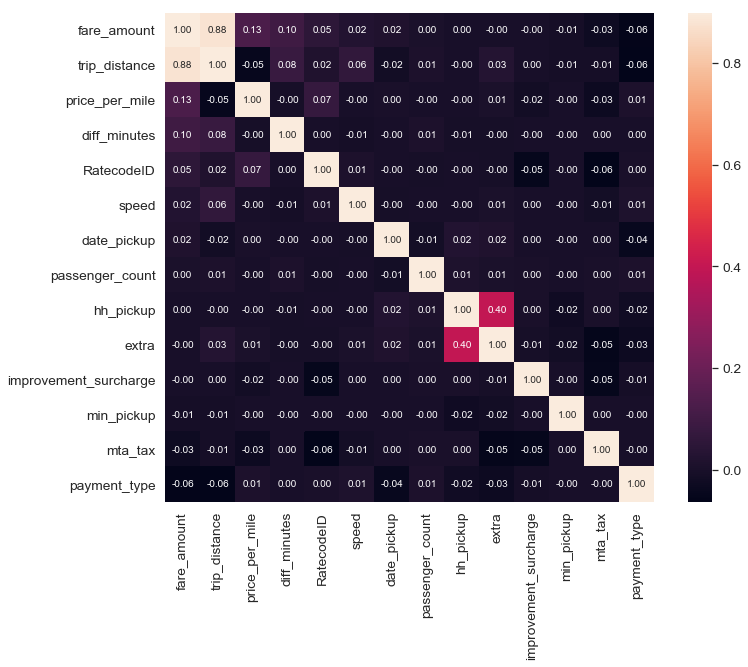

In [82]:
corr_matrix = data_treated[['passenger_count', 'trip_distance', 'RatecodeID',
        'payment_type', 'extra', 'mta_tax',
        'improvement_surcharge',
        'hh_pickup', 'min_pickup',
        'date_pickup',
       'diff_minutes', 'speed', 'price_per_mile','fare_amount']].corr()
k = 14 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'fare_amount')['fare_amount'].index
cm = np.corrcoef(data_treated[cols].values.T)
sns.set(font_scale=1.25)
plt.subplots(figsize=(12,9))
hm = sns.heatmap(cm, cbar=True, annot=True, vmax=0.9, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

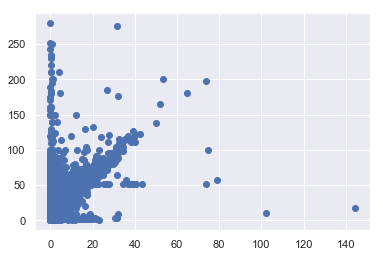

In [95]:
plt.scatter(data_treated['trip_distance'],data_treated['fare_amount'])

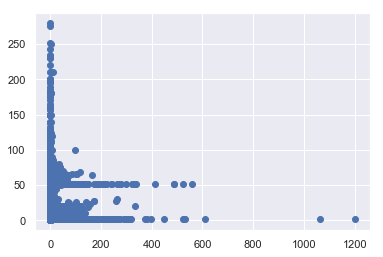

In [122]:
plt.scatter(data_treated['speed'],data_treated['fare_amount'])

In [ ]:
X = data_treated[['passenger_count', 'trip_distance', 'RatecodeID',
        'payment_type', 'extra', 'mta_tax',
        'improvement_surcharge',
        'hh_pickup', 'min_pickup',
        'date_pickup',
       'diff_minutes', 'speed', 'price_per_mile']]
Y = data_treated[['fare_amount']]

In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6178284 entries, 0 to 7667706
Data columns (total 15 columns):
passenger_count          int64
trip_distance            float64
RatecodeID               int64
PULocationID             int64
DOLocationID             int64
payment_type             int64
extra                    float64
mta_tax                  float64
improvement_surcharge    float64
hh_pickup                uint8
min_pickup               uint8
date_pickup              int64
diff_minutes             float64
speed                    float64
price_per_mile           float64
dtypes: float64(7), int64(6), uint8(2)
memory usage: 671.7 MB


In [97]:
X = pd.get_dummies(X, columns=['RatecodeID','payment_type'])

In [ ]:
#Y['total_amount'].skew()

In [ ]:
#Y['total_amount'] = np.log1p(Y['total_amount'])

In [ ]:
Y['fare_amount'] = np.log1p(Y['fare_amount'])

In [ ]:
sns.distplot(Y['fare_amount'], color='blue')

In [67]:
from random import sample 

In [98]:
x = X.sample(n = 50000, random_state = 2) 

In [69]:
y = Y.sample(n = 50000, random_state = 2)

In [99]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state = 2)

**XGBoost**

In [114]:
model = XGBRegressor()
model.fit(xTrain,yTrain);

[12:43:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [115]:
yXGB_predict = model.predict(xTest)

model_error = sqrt(mean_squared_error(np.expm1(yTest), np.expm1(yXGB_predict)))

print(f'XGBoost Mean Squared Error - {model_error}')

XGBoost Mean Squared Error - 1.0504061211114957


Hyperparameter tuning

In [106]:
parameters = {
                 'learning_rate': [0.05,0.08, 0.1, 0.2, 0.3],
                 'max_depth': [3, 5, 7],
                 'n_estimators': [200, 300, 400, 500]
             }

XGB_hyper_params = GridSearchCV(estimator=XGBRegressor(), param_grid=parameters, n_jobs=-1, cv=5)

In [107]:
XGB_hyper_params.fit(xTrain, yTrain)
# find out the best hyper parameters
print(XGB_hyper_params.best_params_)

[12:22:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}


In [108]:
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=3, n_estimators=500)
XGB_model.fit(xTrain, yTrain)
y_XGB_predict = XGB_model.predict(xTest)

XGB_model_error = sqrt(mean_squared_error(np.expm1(yTest), np.expm1(yXGB_predict)))

print(f'XGBoost Mean Squared Error - {XGB_model_error}')

[12:36:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Mean Squared Error - 1.0504061211114957


In [116]:
feature_imp_XGB = pd.DataFrame(model.feature_importances_,
                                   index = xTrain.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [117]:
feature_imp_XGB

,importance
diff_minutes,0.643
trip_distance,0.207
RatecodeID_1,0.085
RatecodeID_2,0.048
speed,0.008
price_per_mile,0.004
RatecodeID_5,0.002
date_pickup,0.001
extra,0.001
PULocationID,0.001


**RandomForest Regression**

In [118]:
rand_forest_regressor = RandomForestRegressor()
rand_forest_regressor.fit(xTrain, yTrain)
## And score it on your testing data.
print(rand_forest_regressor.score(xTest, yTest))

y_rand_forest_predict = rand_forest_regressor.predict(xTest)
random_forest_model_error = sqrt(mean_squared_error(np.expm1(yTest), np.expm1(y_rand_forest_predict)))
print(f' Random Forest Mean Squared Error - {random_forest_model_error}')

C:\Users\Jeevisha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Jeevisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9921915030839782
 Random Forest Mean Squared Error - 1.1023153023777301


In [88]:
param_grid={
   'max_depth': range(3,8),
   'n_estimators': ( 50, 100, 200, 400, 500),
   'min_samples_split': np.linspace(0.3, 0.6, 4, endpoint=True),
   'min_samples_leaf' : np.linspace(0.1, 0.3, 3, endpoint=True),
   'max_features' : list(range(1, X.shape[1]))
            }

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(xTrain, yTrain)
print(grid_search.best_params_)

Fitting 3 folds for each of 4200 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.3, 'n_estimators': 100}


In [119]:
y_rand_forest_predict = rand_forest_regressor.predict(xTest)
random_forest_model_error = sqrt(mean_squared_error(np.expm1(yTest), np.expm1(y_rand_forest_predict)))
print(f' Random Forest Mean Squared Error - {random_forest_model_error}')

 Random Forest Mean Squared Error - 1.1023153023777301


**Feature Importance**

In [120]:
feature_importances = pd.DataFrame(rand_forest_regressor.feature_importances_,
                                   index = xTrain.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [121]:
feature_importances

,importance
diff_minutes,0.794
trip_distance,0.178
RatecodeID_1,0.011
price_per_mile,0.006
RatecodeID_2,0.005
speed,0.004
mta_tax,0.000
RatecodeID_3,0.000
DOLocationID,0.000
RatecodeID_5,0.000


**Light GBM**

In [80]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=35, n_estimators=300)

lgb_model.fit(xTrain, yTrain)
y_LGB_predict = lgb_model.predict(xTest)

LGB_model_error = sqrt(mean_squared_error(np.expm1(yTest), np.expm1(y_LGB_predict)))

print(f'LGBM Mean Squared Error - {LGB_model_error}')

LGBM Mean Squared Error - 0.9006486797070714


In [87]:
# making prediction using test_dataset predictors
#y_XGB_predict = np.expm1(XGB_model.predict(X_test_dataset))